# Is podium


## Dependencies


The dependencies used are as follows


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier, XGBRegressor, XGBRanker

import sys

sys.path.append("..")

from utils.visualization import model_selection
from utils.custom_cvs import VariableTimeSeriesSplit
from utils.custom_scorers import balanced_accuracy_score, balanced_accuracy_ranker

import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Initialization


We continue with the selection of the model that predicts the podium


In [2]:
df = pd.read_csv("../assets/data/processed/final_model.csv")

mid_rc = df.groupby("raceYear")["raceRound"].max().to_numpy() // 2
get_half = lambda x: f'{x["raceYear"]}{x["raceRound"] <= mid_rc[x["raceYear"] - 2006]}'
instances_per_half = df.apply(get_half, axis=1).value_counts(sort=False).to_numpy()

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})

X = pd.read_csv("../assets/data/processed/final_model_X.csv")
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: x["driverRef"] in x["driverRefPodium"], axis=1)

## K-Nearest Neighbors


PI: 0.771 with (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
	20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
	43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63) ==
	('carNumber', 'circuitAlt', 'circuitCountry', 'circuitDirection', 'circuitDist',
	'circuitLaps', 'circuitLat', 'circuitLength', 'circuitLng', 'circuitLocation',
	'circuitRef', 'circuitType', 'constructorNationality', 'constructorRef',
	'constructorWins', 'driverAgeAtRace', 'driverAgeStarted', 'driverAgeToday',
	'driverAwa', 'driverExp', 'driverExpRace', 'driverExpYear', 'driverNationality',
	'driverNumber', 'driverOvr', 'driverPac', 'driverPodiums', 'driverPos10',
	'driverPos11', 'driverPos12', 'driverPos13', 'driverPos14', 'driverPos15',
	'driverPos16', 'driverPos17', 'driverPos18', 'driverPos2', 'driverPos3', 'driverPos4',
	'driverPos5', 'driverPos6', 'driverPos7', 'driverPos8', 'driverPos9', 'driverRac',
	'driverRef', 'driv

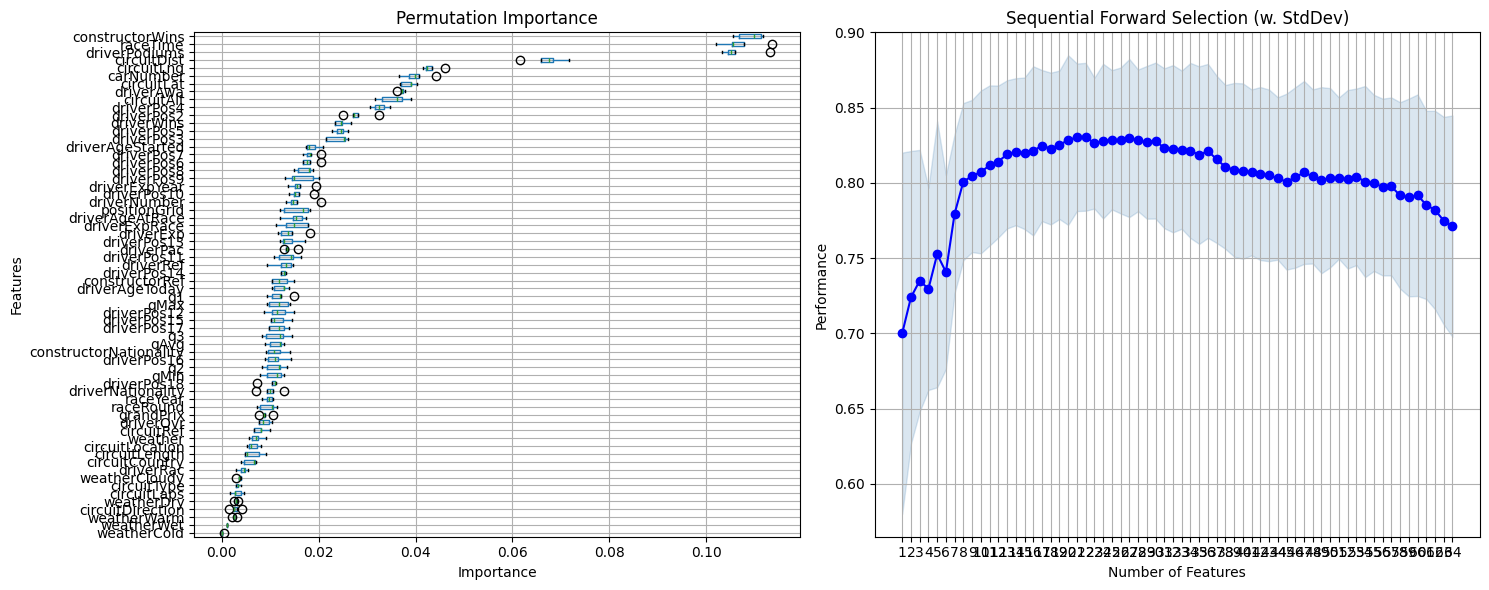

In [3]:
knn = KNeighborsClassifier(n_neighbors=9, metric="cosine", weights="distance")
scoring = make_scorer(balanced_accuracy_score)
model_selection(knn, X, y, tscv, scoring)

## Decision Tree


PI: 0.791 with (1, 18) == ('constructorWins', 'positionGrid')
SFS: 0.829 with (1, 4, 9, 17, 33, 38, 42, 44, 49) == ('positionGrid',
	'driverNationality', 'grandPrix', 'driverWins', 'circuitLaps', 'driverAgeStarted',
	'driverPos2', 'driverPos4', 'driverPos9')
GA: 0.816 with (1, 3, 4, 6, 8, 9, 11, 12, 13, 14, 16, 18, 20, 24, 27, 30, 33, 35, 44,
	53, 54, 56, 59) == ('positionGrid', 'driverNumber', 'driverNationality',
	'constructorNationality', 'raceRound', 'grandPrix', 'circuitRef', 'circuitLocation',
	'circuitCountry', 'circuitLat', 'circuitAlt', 'constructorWins', 'q2', 'weather',
	'weatherDry', 'circuitType', 'circuitLaps', 'qMin', 'driverPos4', 'driverPos13',
	'driverPos14', 'driverPos16', 'driverExp')


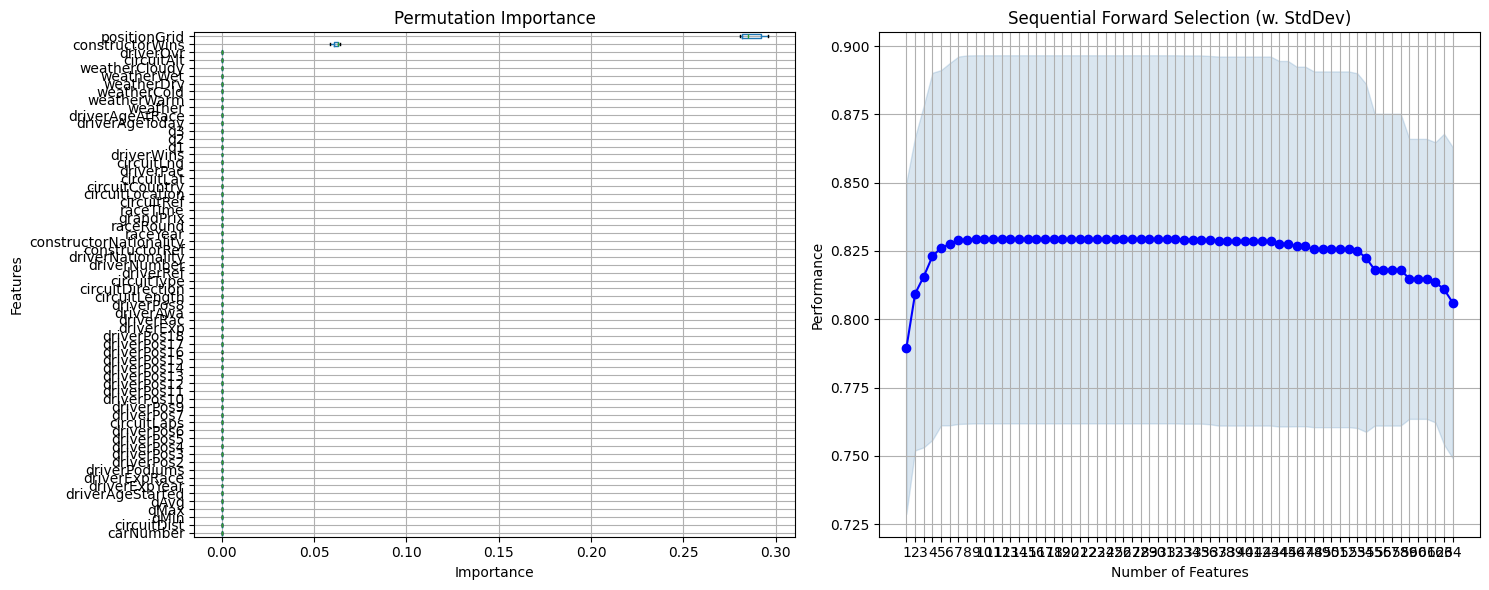

In [4]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, splitter="best")
scoring = make_scorer(balanced_accuracy_score)
model_selection(tree, X, y, tscv, scoring)

## Random Forest


PI: 0.803 with (0, 1, 2, 3, 5, 6, 7, 9, 12, 13, 15, 16, 17, 18, 19, 20, 22, 32, 33, 35,
	36, 38, 39, 40, 41, 42, 43, 44, 45, 49, 50, 51, 52, 53, 54, 55, 56, 58, 60, 62, 63) ==
	('carNumber', 'circuitAlt', 'circuitCountry', 'circuitLaps', 'circuitLength',
	'circuitLng', 'circuitLocation', 'constructorNationality', 'constructorRef',
	'constructorWins', 'driverAgeStarted', 'driverAgeToday', 'driverExpRace',
	'driverExpYear', 'driverNumber', 'driverOvr', 'driverPac', 'driverPodiums',
	'driverPos10', 'driverPos11', 'driverPos12', 'driverPos13', 'driverPos14',
	'driverPos15', 'driverPos16', 'driverPos18', 'driverPos2', 'driverPos3', 'driverPos4',
	'driverPos5', 'driverPos9', 'driverRac', 'driverRef', 'driverWins', 'grandPrix',
	'positionGrid', 'q1', 'q2', 'qMax', 'qMin', 'raceYear')
SFS: 0.826 with (1, 3, 5, 7, 17, 18, 27, 38, 41, 42, 49, 50, 51, 52, 57, 59, 60) ==
	('positionGrid', 'driverNumber', 'constructorRef', 'raceYear', 'driverWins',
	'constructorWins', 'weatherDry', 'driverAgeStarte

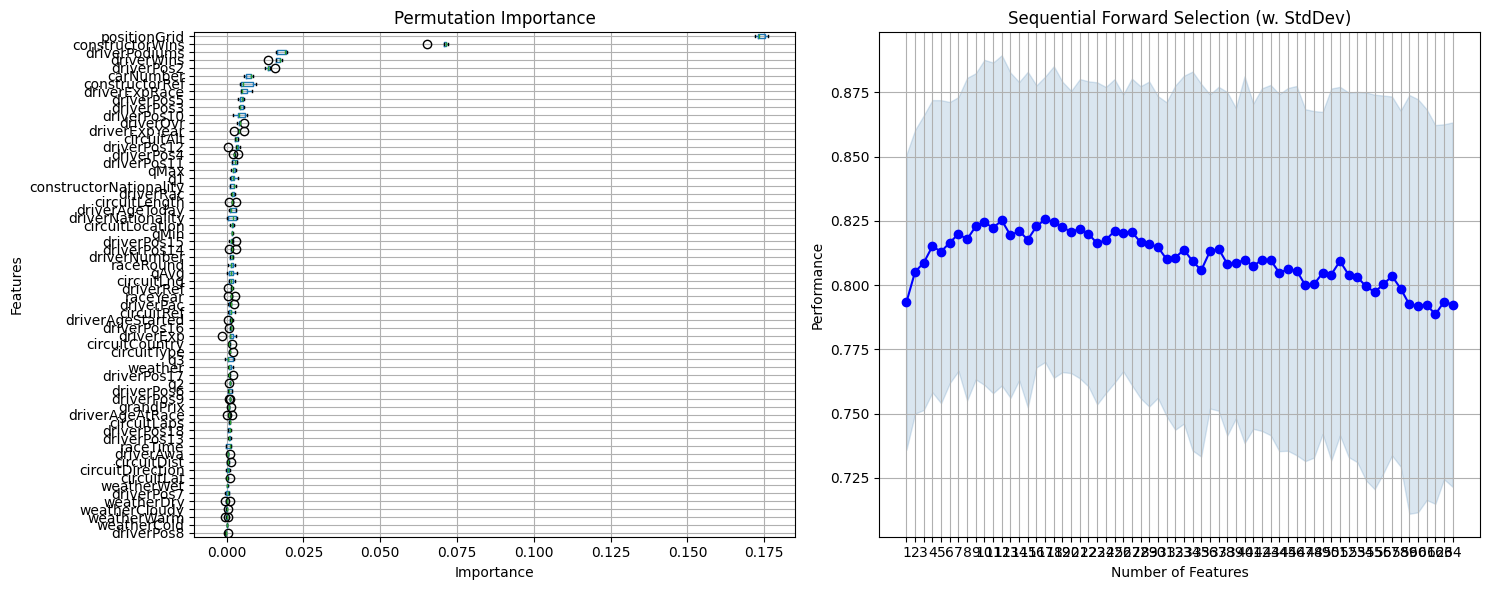

In [5]:
random_forest = RandomForestClassifier(criterion="gini", max_depth=6, n_estimators=100)
scoring = make_scorer(balanced_accuracy_score)
model_selection(random_forest, X, y, tscv, scoring)

## Multilayer Perceptron


PI: 0.815 with (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
	20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44,
	45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63) ==
	('carNumber', 'circuitAlt', 'circuitCountry', 'circuitDirection', 'circuitDist',
	'circuitLaps', 'circuitLat', 'circuitLng', 'circuitLocation', 'circuitRef',
	'circuitType', 'constructorNationality', 'constructorRef', 'constructorWins',
	'driverAgeAtRace', 'driverAgeStarted', 'driverAwa', 'driverExp', 'driverExpRace',
	'driverExpYear', 'driverNationality', 'driverNumber', 'driverOvr', 'driverPac',
	'driverPodiums', 'driverPos10', 'driverPos11', 'driverPos12', 'driverPos13',
	'driverPos14', 'driverPos15', 'driverPos16', 'driverPos17', 'driverPos18',
	'driverPos2', 'driverPos3', 'driverPos4', 'driverPos5', 'driverPos6', 'driverPos7',
	'driverPos8', 'driverPos9', 'driverRef', 'driverWins', 'grandPrix', 'positionGrid',
	'q1', 'q2', 'q3', 'qMa

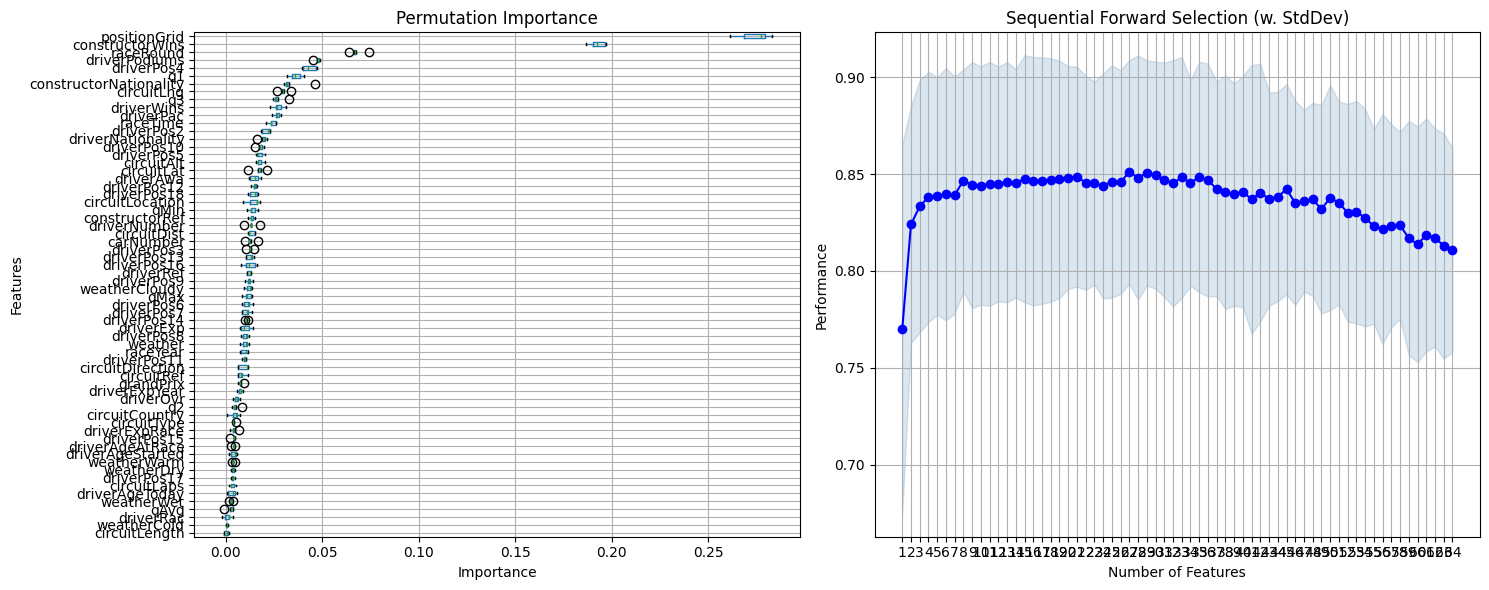

In [6]:
nn = MLPClassifier(activation="logistic", hidden_layer_sizes=(50, 20, 5))
scoring = make_scorer(balanced_accuracy_score)
model_selection(nn, X, y, tscv, scoring)

## XGBClassifier


PI: 0.812 with (0, 1, 3, 17, 18, 40, 41, 42, 43, 45, 47, 50, 52, 55, 62, 63) ==
	('carNumber', 'constructorWins', 'driverExpRace', 'driverNumber', 'driverOvr',
	'driverPac', 'driverPodiums', 'driverPos10', 'driverPos12', 'driverPos15',
	'driverPos2', 'driverPos3', 'driverPos5', 'driverPos7', 'driverWins', 'positionGrid')
SFS: 0.826 with (0, 1, 3, 5, 14, 15, 16, 34, 41, 42, 55, 57, 63) == ('carNumber',
	'positionGrid', 'driverNumber', 'constructorRef', 'circuitLat', 'circuitLng',
	'circuitAlt', 'circuitDist', 'driverPodiums', 'driverPos2', 'driverPos15',
	'driverPos17', 'driverOvr')
GA: 0.819 with (0, 1, 2, 3, 4, 5, 9, 10, 11, 15, 28, 29, 31, 34, 35, 36, 37, 40, 41, 42,
	43, 44, 48, 51, 53, 54, 55, 56, 58, 59, 61, 62, 63) == ('carNumber', 'positionGrid',
	'driverRef', 'driverNumber', 'driverNationality', 'constructorRef', 'grandPrix',
	'raceTime', 'circuitRef', 'circuitLng', 'weatherWet', 'weatherCloudy',
	'circuitDirection', 'circuitDist', 'qMin', 'qMax', 'qAvg', 'driverExpRace',
	'dri

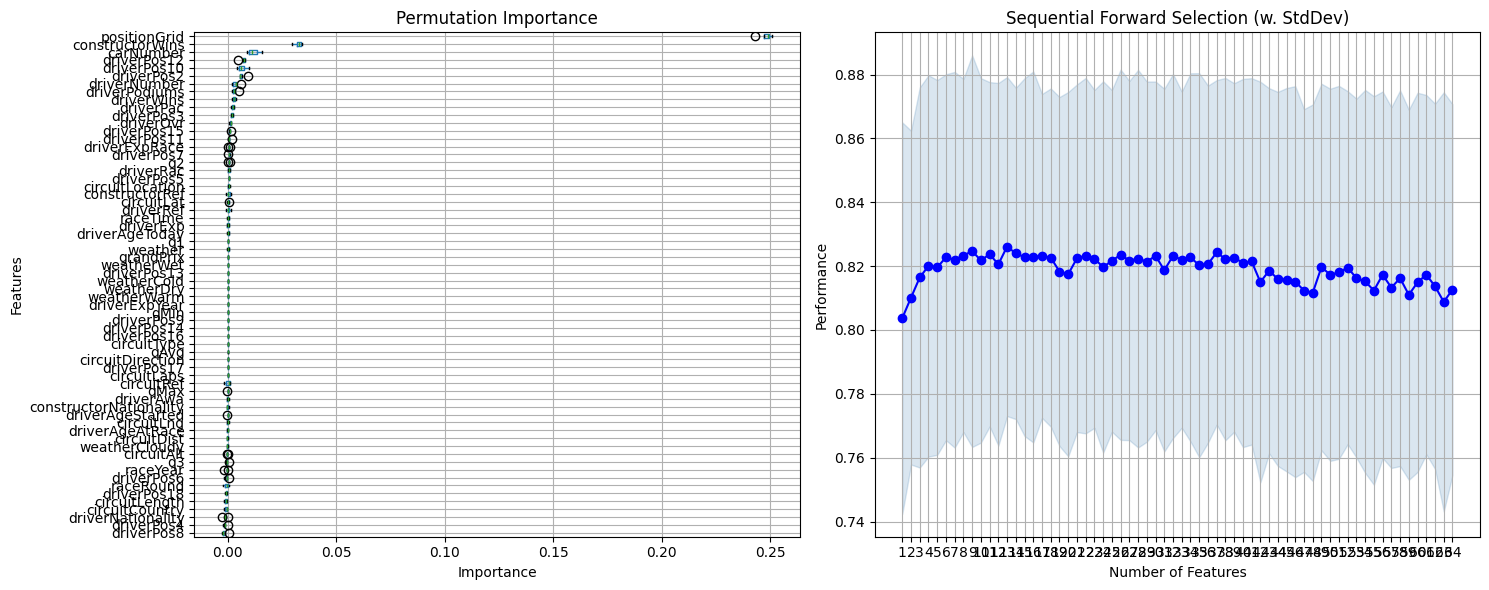

In [7]:
xgbc = XGBClassifier(
    objective="binary:logistic",
    subsample=0.75,
    reg_lambda=10,
    reg_alpha=10,
    n_estimators=50,
    min_child_weight=15,
    max_depth=3,
    learning_rate=0.2,
    gamma=0.5,
    colsample_bytree=0.9,
)
scoring = make_scorer(balanced_accuracy_score)
model_selection(xgbc, X, y, tscv, scoring)

## XGBRegressor


PI: 0.822 with (0, 1, 2, 13, 17, 18, 19, 41, 42, 62) == ('carNumber', 'circuitCountry',
	'constructorWins', 'driverPac', 'driverPodiums', 'driverPos2', 'driverRef',
	'driverWins', 'positionGrid', 'q1')
SFS: 0.834 with (1, 5, 49, 63) == ('positionGrid', 'constructorRef', 'driverPos9',
	'driverOvr')
GA: 0.832 with (0, 1, 2, 3, 8, 12, 14, 16, 17, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35,
	36, 38, 40, 41, 45, 46, 47, 48, 53, 57, 59) == ('carNumber', 'positionGrid',
	'driverRef', 'driverNumber', 'raceRound', 'circuitLocation', 'circuitLat',
	'circuitAlt', 'driverWins', 'weatherWarm', 'weatherCold', 'weatherDry', 'weatherWet',
	'circuitType', 'circuitDirection', 'circuitLength', 'circuitLaps', 'circuitDist',
	'qMin', 'qMax', 'driverAgeStarted', 'driverExpRace', 'driverPodiums', 'driverPos5',
	'driverPos6', 'driverPos7', 'driverPos8', 'driverPos13', 'driverPos17', 'driverExp')


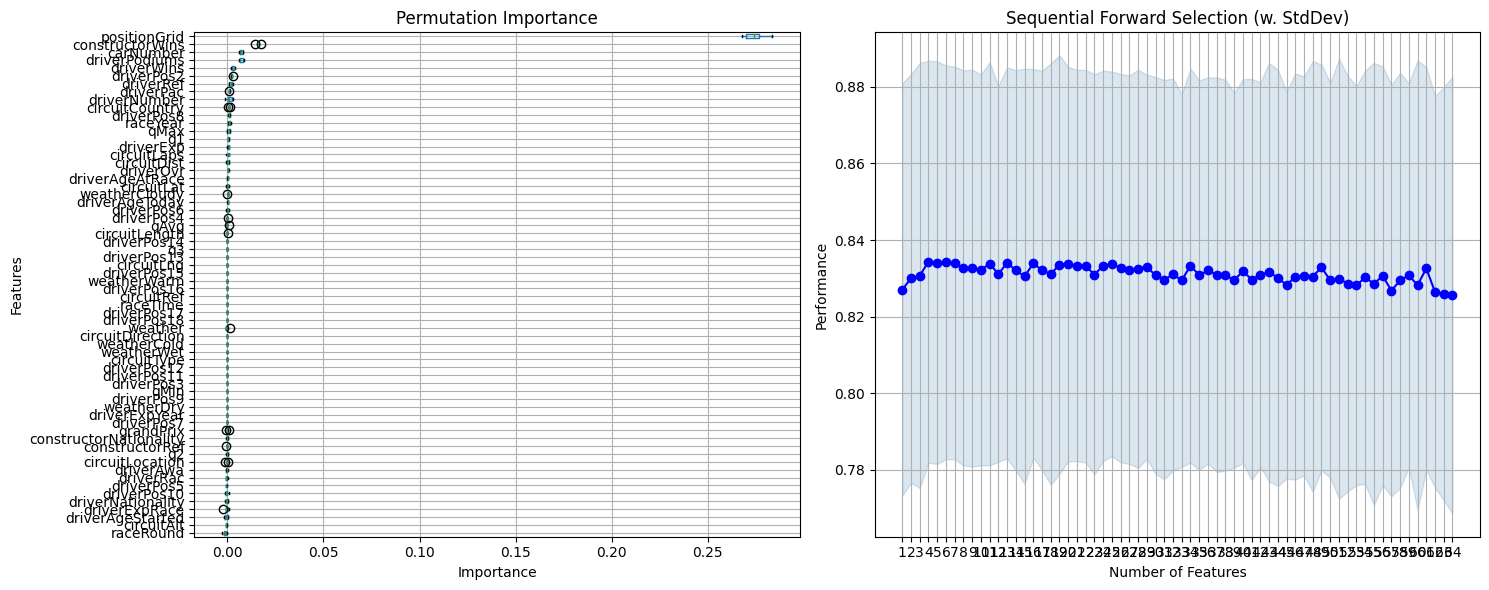

In [8]:
xgbr = XGBRegressor(
    objective="reg:linear",
    subsample=0.75,
    reg_lambda=0,
    reg_alpha=0,
    n_estimators=50,
    min_child_weight=200,
    max_depth=3,
    learning_rate=0.1,
    gamma=0,
    colsample_bytree=0.75,
)
scoring = make_scorer(balanced_accuracy_score)
model_selection(xgbr, X, y, tscv, scoring)

## XGBRanker


PI: 0.837 with (0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
	23, 24, 25, 28, 29, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 45, 48, 50, 58, 59, 60, 61,
	62, 63, 64) == ('carNumber', 'circuitAlt', 'circuitCountry', 'circuitDist',
	'circuitLaps', 'circuitLat', 'circuitLength', 'circuitLng', 'circuitRef',
	'constructorNationality', 'constructorRef', 'constructorWins', 'driverAgeAtRace',
	'driverAgeStarted', 'driverAgeToday', 'driverAwa', 'driverExp', 'driverExpRace',
	'driverExpYear', 'driverNationality', 'driverNumber', 'driverOvr', 'driverPac',
	'driverPodiums', 'driverPos10', 'driverPos18', 'driverPos2', 'driverPos4',
	'driverPos5', 'driverPos8', 'driverRac', 'driverRef', 'driverWins', 'positionGrid',
	'q1', 'q2', 'q3', 'qAvg', 'qid', 'raceRound', 'raceYear', 'weather', 'weatherCloudy',
	'weatherWarm', 'weatherWet')
SFS: 0.849 with (0, 1, 3, 4, 5, 6, 7, 8, 12, 14, 15, 18, 20, 21, 22, 23, 25, 26, 27, 33,
	36, 39, 40, 41, 42, 43, 44, 46, 54, 55, 57, 64) == ('carNu

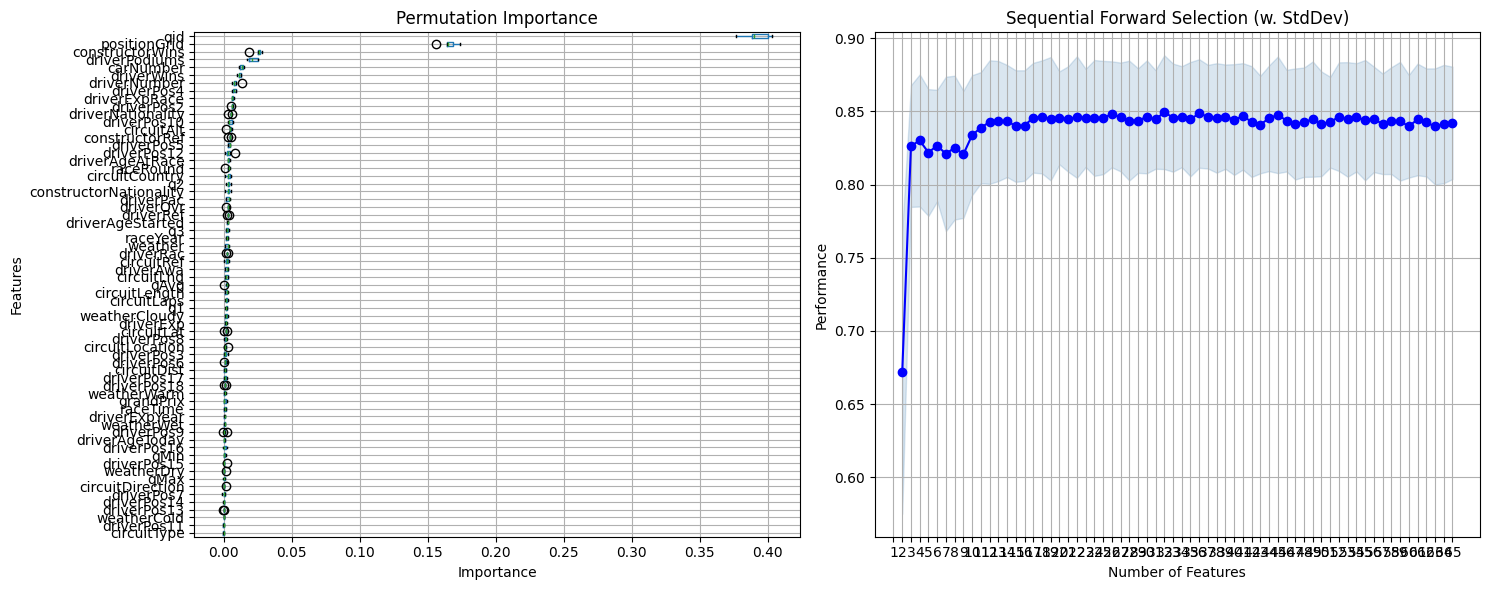

In [9]:
races_per_year = np.cumsum([0] + df.groupby("raceYear")["raceRound"].max().to_list())
set_id = lambda y, r: r + (races_per_year[y - 2006])

X["qid"] = df.apply(lambda x: set_id(x["raceYear"], x["raceRound"]), axis=1)

xgbk = XGBRanker(
    objective="rank:pairwise",
    subsample=0.5,
    reg_lambda=3,
    reg_alpha=0,
    n_estimators=150,
    min_child_weight=15,
    max_depth=5,
    learning_rate=0.01,
    gamma=0.9,
    colsample_bytree=0.5,
)
scoring = balanced_accuracy_ranker
model_selection(xgbk, X, y, tscv, scoring, rank=True)

## Results


Therefore, the selection for each algorithm are as follows

- KNeighborsClassifier: 0.831 with ('carNumber', 'positionGrid', 'driverNationality', 'raceRound', 'circuitLocation', 'driverWins', 'constructorWins', 'weatherCold', 'weatherWet', 'circuitType', 'circuitDirection', 'driverPos7', 'driverPos9', 'driverPos10', 'driverPos11', 'driverPos12', 'driverPos13', 'driverPos14', 'driverPos15', 'driverPos16', 'driverPos17', 'driverRac')
- DecisionTreeClassifier: 0.829 with ('positionGrid', 'driverNationality', 'grandPrix', 'driverWins', 'circuitLaps', 'driverAgeStarted', 'driverPos2', 'driverPos4', 'driverPos9')
- RandomForestClassifier: 0.826 with ('positionGrid', 'driverNumber', 'constructorRef', 'raceYear', 'driverWins', 'constructorWins', 'weatherDry', 'driverAgeStarted', 'driverPodiums', 'driverPos2', 'driverPos9', 'driverPos10', 'driverPos11', 'driverPos12', 'driverPos17', 'driverExp', 'driverRac')
- MLPClassifier: 0.851 with ('positionGrid', 'driverRef', 'driverNationality', 'constructorNationality', 'grandPrix', 'circuitRef', 'circuitLocation', 'circuitLat', 'constructorWins', 'q1', 'q2', 'q3', 'driverAgeToday', 'weatherDry', 'weatherWet', 'circuitLength', 'qMax', 'qAvg', 'driverPos6', 'driverPos7', 'driverPos10', 'driverPos11', 'driverPos15', 'driverPos16', 'driverExp', 'driverRac', 'driverPac')
- XGBClassifier: 0.826 with ('carNumber', 'positionGrid', 'driverNumber', 'constructorRef', 'circuitLat', 'circuitLng', 'circuitAlt', 'circuitDist', 'driverPodiums', 'driverPos2', 'driverPos15', 'driverPos17', 'driverOvr')
- XGBRegressor: 0.834 with ('positionGrid', 'constructorRef', 'driverPos9', 'driverOvr')
- XGBRanker: 0.849 with ('carNumber', 'positionGrid', 'driverNumber', 'driverNationality', 'constructorRef', 'constructorNationality', 'raceYear', 'raceRound', 'circuitLocation', 'circuitLat', 'circuitLng', 'constructorWins', 'q2', 'q3', 'driverAgeToday', 'driverAgeAtRace', 'weatherWarm', 'weatherCold', 'weatherDry', 'circuitLaps', 'qMax', 'driverExpYear', 'driverExpRace', 'driverPodiums', 'driverPos2', 'driverPos3', 'driverPos4', 'driverPos6', 'driverPos14', 'driverPos15', 'driverPos17', 'qid')
